In [140]:
import pandas as pd
import networkx as nx
import re
import numpy as np

In [141]:
reviews_file = open('amazon-meta.txt')
line = reviews_file.readline()
line = reviews_file.readline()
line = reviews_file.readline()

reviews_list = []

customers = {}

for i in range(500000):
    
    review = { }
    id_line = reviews_file.readline()
    
    product_id = re.findall(r'\d+', id_line)[0]
        
    review["id"] =  product_id
    
    asin_line = reviews_file.readline()
    asin = re.findall(r'\d+', asin_line)[0]
    
    review["asin"] = asin
    
    title_line = reviews_file.readline()
    
    title = title_line.replace("title: ", "")
    title = title.replace("\n", "")
    
    review["title"] = title
        
    line = reviews_file.readline()
    
    line = reviews_file.readline()
    
    review["salesrank"] = line
    
    while(not len(re.findall(r'reviews: ', line))):
        line = reviews_file.readline()
        
    review_line = reviews_file.readline()
    customer_id = re.findall(r'\b\w{13,14}\b', review_line)
    
    if(len(customer_id)):
        customer_id = customer_id[0]
        if "customer" not in review.keys():
            review["customer"] = []
        review["customer"].append(customer_id)
        if customer_id not in customers.keys():
            customers[customer_id] = []

        customers[customer_id].append(product_id)
    
    while(review_line[0] != "\n"):
#         print("review line: {}".format(review_line))
        
        review_line = reviews_file.readline()
        
        customer_id = re.findall(r'\b\w{13,14}\b', review_line)
        if not len(customer_id):
            continue
            
        customer_id = customer_id[0]
        
        if "customer" not in review.keys():
            review["customer"] = []
            
        review["customer"].append(customer_id)
        
        if customer_id not in customers.keys():
            customers[customer_id] = []
                
        customers[customer_id].append(product_id)
#         print(review_line)
        
    reviews_list.append(review)
        
reviews_file.close()
    


In [142]:
print(len(customers.items()))

1463886


In [148]:
good_customer = []

for customer, products in customers.items():
    if len(products) >= 400:
        good_customer.append(customer)
        

In [149]:
print(len(good_customer))
print(good_customer[0])
print(len(customers[good_customer[0]]))

436
A2VE83MZF98ITY
969


In [150]:
test_customer = good_customer[98]
number_test_customer_purchases = len(customers[test_customer])
original_customer = [ product for product in customers[test_customer] ]
half = int(number_test_customer_purchases / 2)
mod_customer = customers[test_customer][:half]
future_pur = customers[test_customer][half+1:]
customers[test_customer] = [product for product in mod_customer]

In [151]:
G1 = nx.DiGraph()

for i, customer in enumerate(good_customer):
    for j in range(i+1, len(good_customer)):
        customer2 = good_customer[j]
        p1 = customers[customer]
        p2 = customers[good_customer[j]]
        
        inters = len(np.intersect1d(p1,p2))
        
        if(inters):
            G1.add_edge(customer, customer2, weight=inters)
            G1.add_edge(customer2, customer, weight=inters)

print(G1.number_of_edges())

145616


In [152]:
print(G1.number_of_nodes())

436


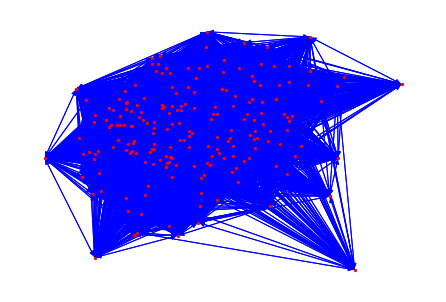

In [147]:
options = {"node_size": 5, "node_color": "r", "edge_color": "b"}
nx.draw(G1, **options)

In [134]:
common_neighbors = [n for n in G1.neighbors(test_customer)]
match = ""
rank = 0

for neighbor in common_neighbors:
    edge_weight = G1.get_edge_data(test_customer, neighbor)["weight"]
    if rank < edge_weight:
        rank = edge_weight
        match = neighbor
        
set_similar = customers[match]
int_length = len(np.intersect1d(set_similar, future_pur))

print("Future purchases: {}".format(len(future_pur)))
print("Good recommendations: {}".format(int_length))
print("Accuracy: {}".format(int_length/len(future_pur)))

Future purchases: 944
Good recommendations: 550
Accuracy: 0.5826271186440678


In [135]:
weighted_personalized_pagerank_cc = nx.pagerank(G1, alpha=0.85)
# weighted_personalized_pagerank = nx.pagerank(G1, alpha=0.85, personalization={test_customer: 1})

match_cc = ""
rank_cc = 0

for similar_customer_cc, val_cc in weighted_personalized_pagerank_cc.items():
    if val_cc > rank_cc:
        rank_cc = val
        match_cc = similar_customer_cc
        
set_similar_cc = customers[match_cc]

int_similar_cc = np.intersect1d(set_similar_cc, future_pur)

int_len_cc = len(int_similar_cc)
accuracy_cc = int_len_cc / len(future_pur)

print("Future purchases: {}".format(len(future_pur)))
print("Good recommendations: {}".format(int_len_cc))
print("Accuracy: {}".format(accuracy_cc))

Future purchases: 944
Good recommendations: 0
Accuracy: 0.0


In [136]:
G2 = nx.DiGraph()
for i, customer in enumerate(good_customer):
    products = customers[customer]
    
    for product in products:
        G2.add_edge(customer, product)
        G2.add_edge(product, customer)

In [ ]:
options = {"node_size": 5, "node_color": "r", "edge_color": "b"}
nx.draw(G2, **options)

In [138]:
weighted_prank2 = nx.pagerank(G2, alpha=0.85)
# weighted_prank2 = nx.pagerank(G2, alpha=0.85, personalization={test_customer: 1})
        
lenghts = [13, 14]
        
best_products = [ [node, value] for node, value in weighted_prank2.items() if len(node) not in lenghts ]

best_match = ""
best_rank = 0

best_products = sorted(best_products, key=lambda p: p[1])

set_similar_cp = best_products[:len(future_pur)]

set_similar_cp = [ val[0] for val in set_similar_cp ]

int_similar_cp = np.intersect1d(set_similar_cp, future_pur)

int_len_cp = len(int_similar_cp)
accuracy = int_len_cp / len(future_pur)

print("Future purchases: {}".format(len(future_pur)))
print("Good recommendations: {}".format(int_len_cp))
print("Accuracy: {}".format(int_len_cp/len(future_pur)))

Future purchases: 944
Good recommendations: 3
Accuracy: 0.0031779661016949155
